# House Price Prediction2
I decided to Fork the Notebook and  change some of the features.(log of saleprice).
Scaling the Saleprice seems to have a very positive impact on the acc. of the models.

# Imports

In [1]:
import numpy as np 
import pandas as pd 


# plot
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import  norm
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import RobustScaler 
#This Scaler removes the median and scales the data according to the quantile range
# better for models like SVR

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# import warnings 
# warnings.filterwarnings('ignore')

print("imports sucessful")

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
imports sucessful


# Data Processing

In [2]:
train=pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv", index_col="Id")
test=pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv", index_col="Id")
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [3]:
print("Train.shape: ", train.shape, "\tTest.shape: ", test.shape)

Train.shape:  (1460, 80) 	Test.shape:  (1459, 79)


In [4]:
trainY=train.pop("SalePrice")
trainY

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1460, dtype: int64

In [5]:
trainLen=len(train)
allData=pd.concat((train,test)).reset_index(drop=True)
allData

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


We first want to find and get rid of NaN

In [6]:
objCols = allData.select_dtypes(include=['object']).columns
numCols =allData.select_dtypes(exclude=['object']).columns
objCols

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [7]:
numCols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [8]:
print("len num: ", len(numCols),"\tlen num: ", len(objCols))  #a+b=79   so check if we have all in a category

len num:  36 	len num:  43


In [9]:
nan=[col for col in allData.columns if allData[col].isnull().sum()>0] #List of Cols with nan
print(nan)

['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [10]:
print(allData['MasVnrType'].isnull().sum(),allData["MasVnrArea"].isnull().sum()) # =no type=> no area? =>no mas..

24 23


In [11]:
print(allData['GarageType'].isnull().sum(),allData["GarageYrBlt"].isnull().sum())  #similar => no garage=> no jear built

157 159


In [12]:
allData['KitchenQual'].isnull().sum()  # 1 missing   maybe no kitchen

1

In [13]:
# a nan in fireplace. pool etc => no pool/fireplace etc.  Exterior2nd=Nan=probl just 1 material    no basement parameters=> probl no basement...
# you can get information from the data_description.txt
# these assumtions might be false sometime, but the results should be much better than dropping important cols like pool
cat=["Fence","PoolQC", "MiscFeature", "Alley",'FireplaceQu', 'MasVnrType',"Exterior2nd", "BsmtCond","BsmtExposure","BsmtFinType1", "BsmtFinType2", "KitchenQual", 
   "GarageType", "GarageFinish", "GarageQual", 'GarageCond', "BsmtQual"]#fill with None
num=["BsmtFinSF1","MasVnrArea","BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "GarageYrBlt", "GarageCars", "GarageArea", ] #fill with 0
for i in cat:
    allData[i].fillna(value="None", inplace=True)
for i in num:
    allData[i].fillna(value=0, inplace=True)

In [14]:
nan=[col for col in allData.columns if allData[col].isnull().sum()>0] #List of Cols with nan   after filling in stuff
print(nan) # these are the Parameters that you cant fill as easily(as far as i can see)

['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Electrical', 'Functional', 'SaleType']


In [15]:
for i in nan:
    print(allData[i].isnull().sum())  # only LotFrontage has a lot of missing vals

4
486
2
1
1
2
1


In [16]:
tiny=['MSZoning', 'Utilities', 'Exterior1st', 'Electrical', 'Functional','SaleType']
allData[tiny] = allData[tiny].fillna(allData.mode().iloc[0])  #fill cat with most common

In [17]:
nan=[col for col in allData.columns if allData[col].isnull().sum()>0] #List of Cols with nan   after filling in stuff
nan # LotFrontage is numerical  = Linear feet of street connected to property
#there are a lot of missing vals   I don't think this parametier is very Important to the price of a House but im not an expert

['LotFrontage']

In [18]:
allData["LotFrontage"] = allData["LotFrontage"].fillna(allData["LotFrontage"].mean())  #fill with mean

now that we have gotten rid of NaN we have to further prep the data

In [19]:
numCols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

notes: <br>
- Maybe we could change YrSold and similar parameters to sold x years ago, which could improve the performance, but I dont't know what time the data has been collected. I will use 2020 as the "now" time. 
- I decide not to combine month and year. Month on its own shows which season the sale took place which could have an impact.

In [20]:
# new cols, that might get insight/make it more obvious
allData["SoldYrAgo"]=2020-allData["YrSold"]
allData["GarageYrBltAgo"]=2020-allData["GarageYrBlt"]
allData["BuiltAgo"]=2020-allData["YearBuilt"]
allData["SoldYrAgo"]

0       12
1       13
2       12
3       14
4       12
        ..
2914    14
2915    14
2916    14
2917    14
2918    14
Name: SoldYrAgo, Length: 2919, dtype: int64

In [21]:
#creating the data to plot with later   before scaling... happens
plotdata=allData[:trainLen]
plotdata["Saleprice"]=trainY

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
#onehot cols that are not linear
# i dont replace all categorical cols, because some should work fine in 1 col, i m looking at the data_description
neededOneHot=["MSZoning", "MSSubClass", "LandContour", "Utilities", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", 
       "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterCond",  "Foundation",  "Heating", "Electrical", "GarageType", "MiscFeature",
        "SaleType", "SaleCondition"]

In [23]:
enc = OneHotEncoder(handle_unknown='ignore')
for col in neededOneHot:
    allData=pd.concat([allData,pd.get_dummies(allData[col],prefix=col)], axis=1)
    allData.drop([col],axis=1, inplace=True)

In [24]:
allData.shape

(2919, 245)

In [25]:
allData.BsmtFinType2.unique()

array(['Unf', 'BLQ', 'None', 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [26]:
# manually concerting "quality" parameters
trans = {"Grvl": 0, "Pave": 1, "None": 2,}
allData['Alley']= allData['Alley'].map(trans)

trans = {"Reg": 0, "IR1": 1, "IR2": 2, "IR3": 3, "None": 4}
allData['LotShape']= allData['LotShape'].map(trans)

trans = {"Gtl": 0, "Mod": 1, "Sev": 2, "None": 3}
allData['LandSlope']= allData['LandSlope'].map(trans)

trans = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, "None": 5}
allData['ExterQual']= allData['ExterQual'].map(trans)

trans = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4,  "None": 5}
allData['BsmtQual']= allData['BsmtQual'].map(trans)

trans = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4,  "None": 5}
allData['BsmtCond']= allData['BsmtCond'].map(trans)

trans = { "Gd": 1, "Av": 2, "Mn": 3, "No": 4,  "None": 5}
allData['BsmtExposure']= allData['BsmtExposure'].map(trans)

trans = {"GLQ": 0, "ALQ": 1, "BLQ": 2, "Rec": 3, "LwQ": 4,  "Unf": 5, "None": 6}
allData['BsmtFinType1']= allData['BsmtFinType1'].map(trans)

trans = {"GLQ": 0, "ALQ": 1, "BLQ": 2, "Rec": 3, "LwQ": 4,  "Unf": 5, "None": 6}
allData['BsmtFinType2']= allData['BsmtFinType2'].map(trans)

trans = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, "None": 5}
allData['HeatingQC']= allData['HeatingQC'].map(trans)

trans = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, "None": 5}
allData['KitchenQual']= allData['KitchenQual'].map(trans)

trans = {"Typ": 0, "Min1": 1, "Min2": 2, "Mod": 3, "Maj1": 4,  "Maj2": 5,"Sev": 6,"Sal": 7, "None": 8}
allData['Functional']= allData['Functional'].map(trans)

trans = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, "None": 5}
allData['FireplaceQu']= allData['FireplaceQu'].map(trans)

trans = {"Fin": 0, "RFn": 1, "Unf": 2,  "None": 3}
allData['GarageFinish']= allData['GarageFinish'].map(trans)

trans = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, "None": 5}
allData['GarageQual']= allData['GarageQual'].map(trans)

trans = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, "None": 5}
allData['GarageCond']= allData['GarageCond'].map(trans)

trans = {"Ex": 0, "Gd": 1, "TA": 2, "Fa": 3, "Po": 4, "None": 5}
allData['PoolQC']= allData['PoolQC'].map(trans)

trans = {"GdPrv": 0, "MnPrv": 1, "GdWo": 2, "MnWw": 3,  "None": 5}
allData['Fence']= allData['Fence'].map(trans)

In [27]:
#redo after onehot etc
objCols = allData.select_dtypes(include=['object']).columns
numCols =allData.select_dtypes(exclude=['object']).columns
l=[]
for i in objCols: #showing cat data example
    l.append(allData[i][0:5])
print(l)

[0    Pave
1    Pave
2    Pave
3    Pave
4    Pave
Name: Street, dtype: object, 0    Y
1    Y
2    Y
3    Y
4    Y
Name: CentralAir, dtype: object, 0    Y
1    Y
2    Y
3    Y
4    Y
Name: PavedDrive, dtype: object]


In [28]:
#changing cat. data to num
for i in objCols:
    allData[i]= allData[i].astype('category').cat.codes

l=[]
for i in objCols: #showing they changed to num
    l.append(allData[i][0:5])
print(l)   

[0    1
1    1
2    1
3    1
4    1
Name: Street, dtype: int8, 0    1
1    1
2    1
3    1
4    1
Name: CentralAir, dtype: int8, 0    2
1    2
2    2
3    2
4    2
Name: PavedDrive, dtype: int8]


In [29]:
#drop the cols we have twice
allData.drop("YrSold", axis=1, inplace=True)
allData.drop("GarageYrBltAgo", axis=1, inplace=True)
allData.drop("BuiltAgo", axis=1, inplace=True)

In [30]:
allData.shape #the shape stays the same

(2919, 242)

In [31]:
scaler = MinMaxScaler()
for col in allData.columns:
    allData[col] = scaler.fit_transform(allData[col].values.reshape(-1,1))

In [32]:
allData

,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.150685,0.033420,1.0,1.0,0.000000,0.0,0.666667,0.500,0.949275,0.883333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.202055,0.038795,1.0,1.0,0.000000,0.0,0.555556,0.875,0.753623,0.433333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.160959,0.046507,1.0,1.0,0.333333,0.0,0.666667,0.500,0.934783,0.866667,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.133562,0.038561,1.0,1.0,0.333333,0.0,0.666667,0.500,0.311594,0.333333,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.215753,0.060576,1.0,1.0,0.333333,0.0,0.777778,0.500,0.927536,0.833333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0.000000,0.002973,1.0,1.0,0.000000,0.0,0.333333,0.750,0.710145,0.333333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2915,0.000000,0.002776,1.0,1.0,0.000000,0.0,0.333333,0.500,0.710145,0.333333,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2916,0.476027,0.087406,1.0,1.0,0.000000,0.0,0.444444,0.750,0.637681,0.766667,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2917,0.140411,0.042726,1.0,1.0,0.000000,0.0,0.444444,0.500,0.869565,0.700000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


notes:
I don't think I should remove any col.

In [33]:
trainY

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1460, dtype: int64

In [34]:
# log of saleprice as new saleprice
trainY=np.log1p(trainY)

In [35]:
trainY

Id
1       12.247699
2       12.109016
3       12.317171
4       11.849405
5       12.429220
          ...    
1456    12.072547
1457    12.254868
1458    12.493133
1459    11.864469
1460    11.901590
Name: SalePrice, Length: 1460, dtype: float64

# Plot
I don't know what I want to plot as the nr. of cols is overwhelming and I don't know much about House-Prices. I will edit the data if I see it is needed in here.

In [36]:
# #attention this will take a while
# plt.figure(figsize=(64,48))
# sns.heatmap(plotdata.corr(),annot=True,cmap='Reds')
# plt.show()# a lot of small correlations

As seen on the Heatmap, the correlations between the parameters and Saleprice are very small.<br>
It is also notable that YearBuilt and BuiltAgo for example have the same correlation, which is logical as they say the same thing

In [37]:
plotdata.columns#seel what I can plot with

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Looking at the distribution of some cols

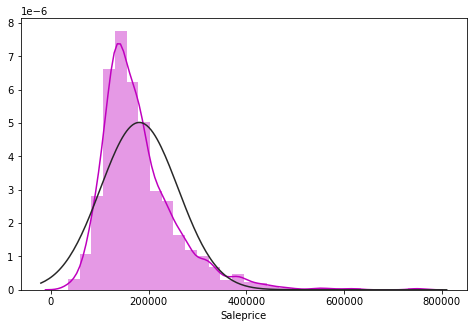

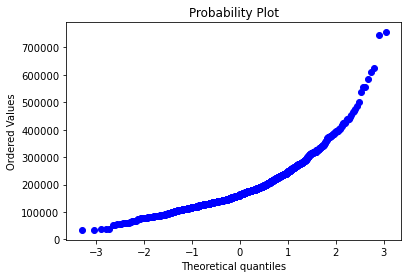

In [38]:
plt.figure(figsize=(8,5))
sns.distplot(plotdata['Saleprice'],bins=30,color='m', fit=norm)
fig = plt.figure()
res = stats.probplot(plotdata['Saleprice'], plot=plt)
# prob. plot from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [39]:
# a lot of ml models work better with norm dist.
plotdata["SalepriceLog"] = np.log1p(plotdata["Saleprice"])
# allData["Saleprice"] = np.log1p(allData["Saleprice"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


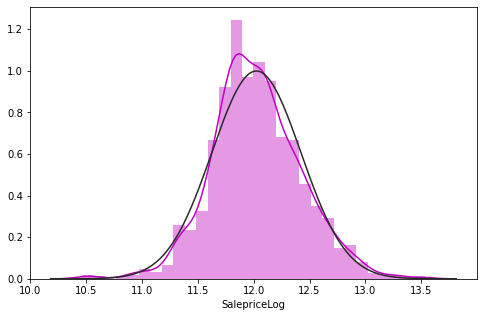

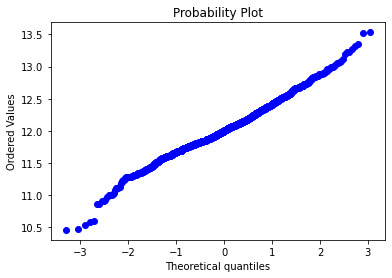

In [40]:
plt.figure(figsize=(8,5))
sns.distplot(plotdata['SalepriceLog'],bins=30,color='m', fit=norm)
fig = plt.figure()
res = stats.probplot(plotdata['SalepriceLog'], plot=plt)# much better
# need to np.expm1() the output to undo the log. for submitting results

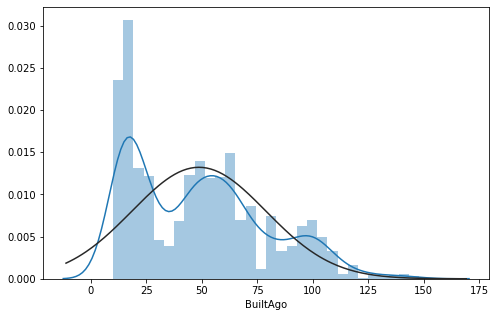

In [41]:
plt.figure(figsize=(8,5))# not a used col
sns.distplot(plotdata['BuiltAgo'],bins=30, fit=norm)# most houses are not that old

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


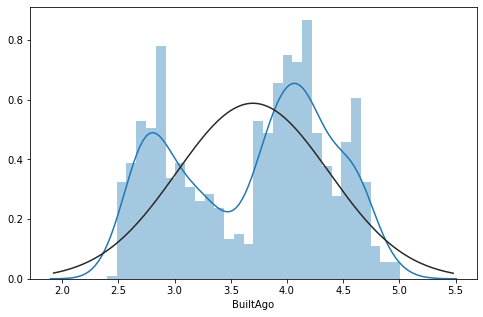

In [42]:
# a lot of ml models work better with norm dist.
plotdata["BuiltAgo"] = np.log1p(plotdata["BuiltAgo"])
plt.figure(figsize=(8,5))
sns.distplot(plotdata['BuiltAgo'],bins=30, fit=norm)# dont know if this is better as it has several bumps I dont change the allData

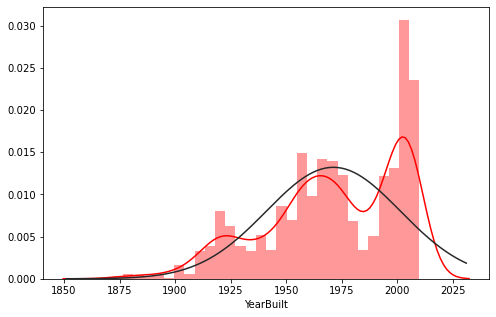

In [43]:
plt.figure(figsize=(8,5))
sns.distplot(plotdata['YearBuilt'],bins=30, fit=norm,color='r')# most houses are not that old

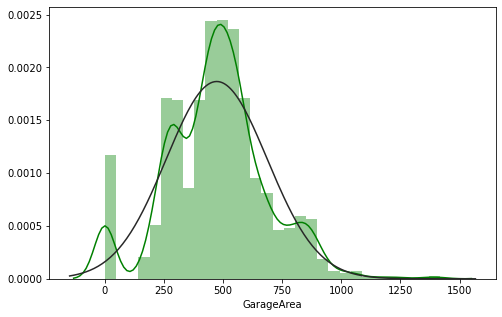

In [44]:
plt.figure(figsize=(8,5))
sns.distplot(plotdata['GarageArea'],bins=30, fit=norm,color='g')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


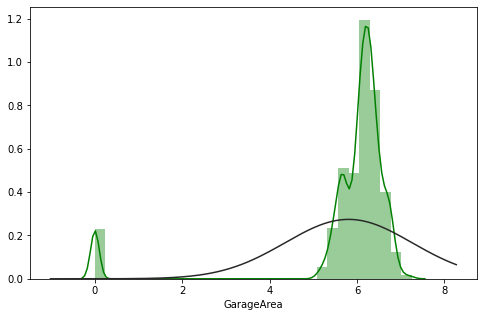

In [45]:
plotdata["GarageArea"] = np.log1p(plotdata["GarageArea"])
plt.figure(figsize=(8,5))
sns.distplot(plotdata['GarageArea'],bins=30, fit=norm,color='g')# much worse?

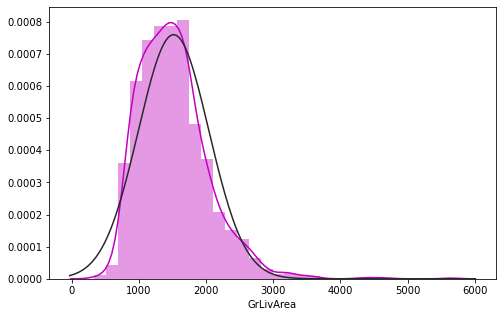

In [46]:
plt.figure(figsize=(8,5))
sns.distplot(plotdata['GrLivArea'],bins=30, fit=norm,color='m')# much worse

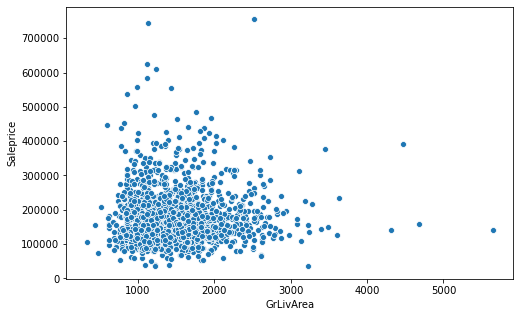

In [47]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="GrLivArea",y="Saleprice",  data=plotdata)

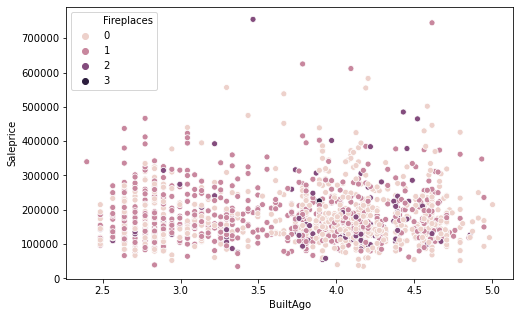

In [48]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="BuiltAgo",y="Saleprice",hue="Fireplaces",  data=plotdata)# fireplaces are nice, but they are not that hard to build if the house does not have one already

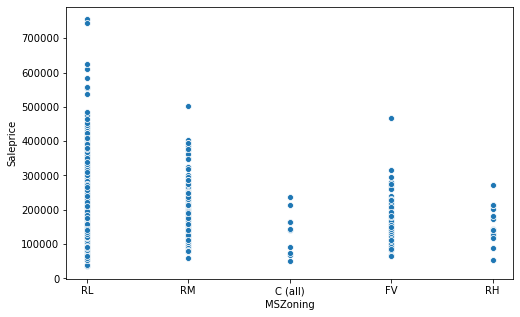

In [49]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="MSZoning",y="Saleprice",  data=plotdata)# some are clearly "cheaper"

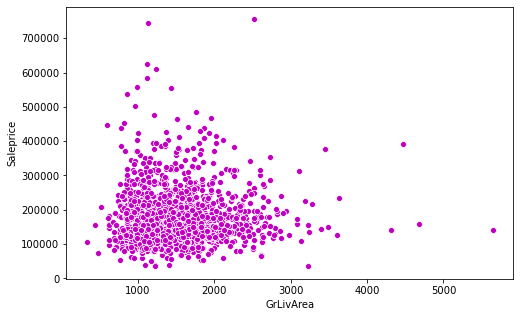

In [50]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="GrLivArea",y="Saleprice",  data=plotdata,color='m') 

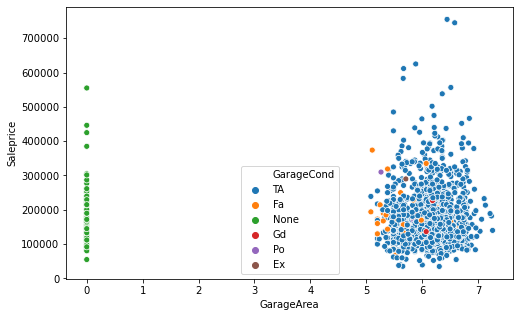

In [51]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="GarageArea",y="Saleprice",hue="GarageCond",  data=plotdata)

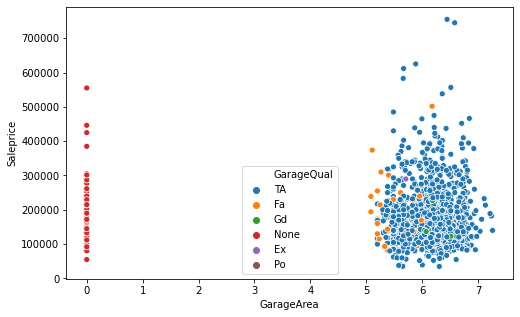

In [52]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="GarageArea",y="Saleprice",hue="GarageQual",  data=plotdata)

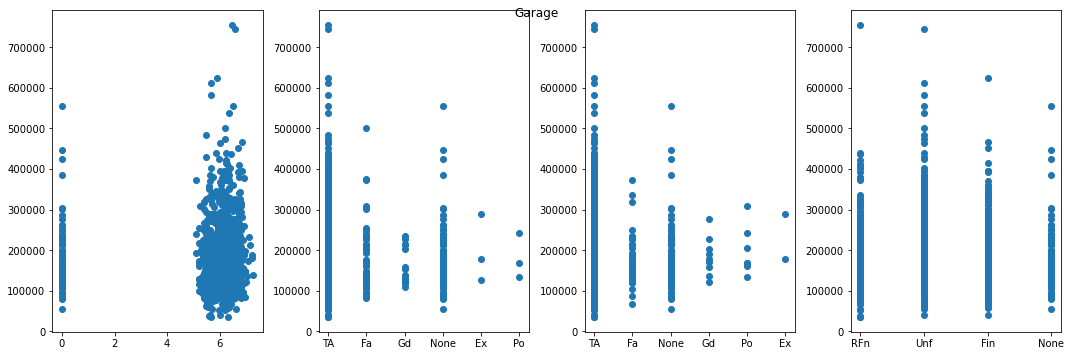

<Figure size 5760x3600 with 0 Axes>

In [53]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,5))
plt.figure(figsize=(80,50))
fig.suptitle('Garage')
ax1.scatter(x="GarageArea",y="Saleprice",  data=plotdata, linewidth=1)
ax2.scatter(x="GarageQual",y="Saleprice",  data=plotdata, linewidth=1)
ax3.scatter(x="GarageCond",y="Saleprice",  data=plotdata, linewidth=1)
ax4.scatter(x="GarageFinish",y="Saleprice",  data=plotdata, linewidth=1)

fig.tight_layout()

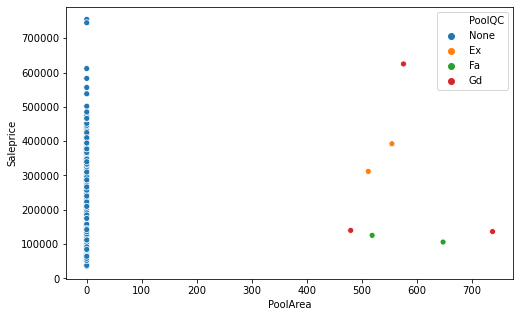

In [54]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="PoolArea",y="Saleprice",hue="PoolQC",  data=plotdata)# a pool does not seem to make a house very expensive interestingly

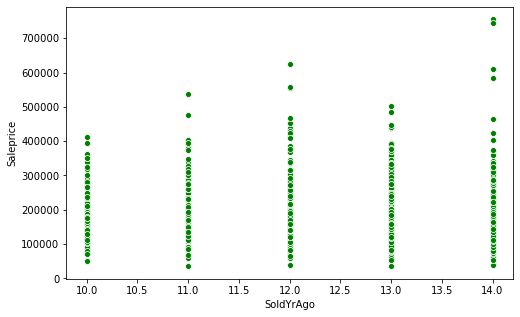

In [55]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="SoldYrAgo",y="Saleprice", data=plotdata,color='g')#older sales=> more expensive  (bubble?)

# Models
testing a lot of several models.

In [56]:
#final nan check
nan=[col for col in allData.columns if allData[col].isnull().sum()>0] #List of Cols with nan   after filling in stuff
print(nan)

[]


In [57]:
#data for the models
trainX=np.array(allData[:trainLen])
testX=np.array(allData[trainLen:])
trainY=np.array(trainY)

# Linear regression

there is a strange bug, wehre saleprice with index 1444 will return inf. But if I use the Robustscaler it works.

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
# modelLin = LinearRegression()
# modelLin.fit(trainX, trainY)
# predTrain=np.expm1(modelLin.predict(trainX))
# LinAcc = mean_squared_error(predTrain, np.expm1(trainY))
# print (str(LinAcc) + ' MSE') #Score= failed(bug?)

In [60]:
# modelLin = make_pipeline(RobustScaler(), LinearRegression())
# modelLin.fit(trainX, trainY)
# predTrain=np.expm1(modelLin.predict(trainX))
# LinAcc = mean_squared_error(predTrain, np.expm1(trainY))
# print (str(LinAcc) + ' MSE') #Score= 0.14579

In [61]:
# # plot results
# plt.figure(figsize=(12,5))
# sns.distplot((np.expm1(trainY)),bins=30, color='m')
# sns.distplot((predTrain),bins=30, color='g')

the score seems to be very bad

# SVR

In [62]:
from sklearn.svm import SVR

manually tunning

In [63]:
# kernels: poly, rbf
modelSvr = make_pipeline(RobustScaler(), SVR(kernel="poly", C=1, degree=1))
modelSvr.fit(trainX,trainY)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('svr', SVR(C=1, degree=1, kernel='poly'))])

In [64]:
predTrain=np.expm1(modelSvr.predict(trainX))
SVRAcc = mean_squared_error(predTrain, np.expm1(trainY))
print (str(SVRAcc) + ' MSE') # huge mse   score=0.13343   #very diffrent than houseprice1

3359490636.129536 MSE


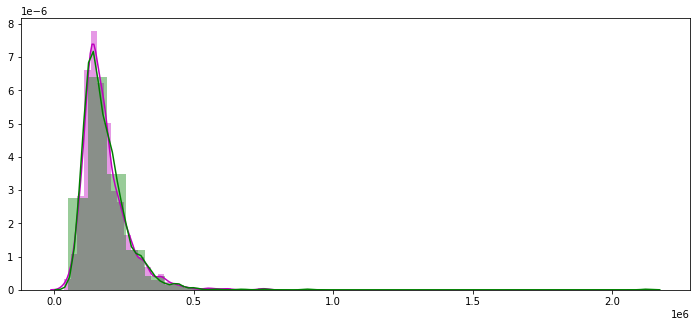

In [65]:
# plot results
plt.figure(figsize=(12,5))
sns.distplot((np.expm1(trainY)),bins=30, color='m')
sns.distplot((predTrain),bins=30, color='g')

# XGBoost

In [66]:
import xgboost

Hypertunning 1<br>
attention, the hypertunning may take a very long time(don't run this for your own sake)

In [67]:
# #xgboost
# modelX=xgboost.XGBRegressor(verbose=2)

# n_estimators = [500, 900, 2000] # a lot of cols=> many estim..
# max_depth = [3, 6,9,12]
# booster=['gbtree','gblinear'] #"dart"
# learning_rate=[.02,.05,.1,.2]
# min_child_weight=[2,5,9]
# base_score=[.01,.25,.5,.75]
# max_depth=[2,4,6,8]
# min_split_loss=[0,0.01,.1]
# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'max_depth':max_depth,
#     'learning_rate':learning_rate,
#     'min_child_weight':min_child_weight,
#     'booster':booster,
#     'base_score':base_score,
#     "max_depth":max_depth,
#     "min_split_loss":min_split_loss}

# random_cv = RandomizedSearchCV(estimator=modelX,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=100,
#             scoring='neg_root_mean_squared_error',
#                                n_jobs = -1,
#             verbose = 5, 
#             return_train_score = True,
#             random_state=42)

# random_cv.fit(trainX,trainY)

In [68]:
# random_cv.best_estimator_    #if best estim are at the edge=> additional tests

In [69]:
# modelX=xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#              importance_type='gain', interaction_constraints='',
#              learning_rate=0.02, max_delta_step=0, max_depth=8,
#              min_child_weight=9, min_split_loss=0, missing=None,
#              monotone_constraints='()', n_estimators=2000, n_jobs=0,
#              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
#              scale_pos_weight=1, subsample=1, tree_method='exact',
#              validate_parameters=1,  verbosity=None)#Score= 0.12949

In [70]:
# modelX=xgboost.XGBRegressor(base_score=0.01, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#              importance_type='gain', interaction_constraints='',
#              learning_rate=0.05, max_delta_step=0, max_depth=4,
#              min_child_weight=5, min_split_loss=0, missing=None,
#              monotone_constraints='()', n_estimators=500, n_jobs=0,
#              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
#              scale_pos_weight=1, subsample=1, tree_method='exact',
#              validate_parameters=1, verbose=2, verbosity=None)#  score = 0.12808

In [71]:
# modelX.fit(trainX,trainY)

In [72]:
# predTrain=np.expm1(modelX.predict(trainX))
# XAcc = mean_squared_error(predTrain, np.expm1(trainY))
# print (str(XAcc) + ' MSE') #Score= 0.12808

manually tunning<br>
after having seen the score of the light GBM i wanted to atleaset go below a score of 0.13

In [73]:
# modelX=xgboost.XGBRegressor( booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#              importance_type='gain', interaction_constraints='',
#              learning_rate=0.015, max_delta_step=0, max_depth=4,
#              min_child_weight=5, min_split_loss=0, missing=None,
#              monotone_constraints='()', n_estimators=3000, n_jobs=0,
#              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
#              scale_pos_weight=1, subsample=1, tree_method='exact',
#              validate_parameters=1,  verbosity=None)
# modelX.fit(trainX,trainY)

In [74]:
# predTrain=np.expm1(modelX.predict(trainX))
# XAcc = mean_squared_error(predTrain, np.expm1(trainY))
# print (str(XAcc) + ' MSE') #Score= 0.12670

In [75]:
# # plot results
# plt.figure(figsize=(12,5))
# sns.distplot((np.expm1(trainY)),bins=30, color='m')
# sns.distplot((predTrain),bins=30, color='g')

Notes: <br>
the 2. Hypertuned XGBoost model has a better MSE with the training data but performs worse with the test data:
- 1 Hyper...= 0.13105 score
- 2 Hyper...= 0.13458 score

# Random Forrest

In [76]:
from sklearn.ensemble import  RandomForestRegressor

Hypertunning 1<br>
attention, the hypertunning may take a long time

In [77]:
# modelForrest=RandomForestRegressor()# not regressor

# #Hypertunning    from https://www.kaggle.com/harshkothari21/beginners-notebook-90-accuracy
# n_estimators = [100,300, 500, 1000]
# depth = [3,5,10,15]
# min_split=[2,3,4]
# min_leaf=[2,3,4]
# bootstrap = ['True', 'False']
# verbose = [5]

# hyperparameter = {
#     'n_estimators': n_estimators,
#     'max_depth':depth,
#     'bootstrap':bootstrap,
#     'verbose':verbose,
#     'min_samples_split':min_split,
#     'min_samples_leaf':min_leaf    }

# modelForrest = RandomizedSearchCV(estimator=modelForrest,
#                                param_distributions=hyperparameter,
#                                cv=5, #n_iter=100,
#                                scoring = 'neg_mean_absolute_error',
#                                n_jobs = 4, 
#                                return_train_score = True,
#                                random_state=1)
# modelForrest.fit(trainX,trainY)

In [78]:
# modelForrest.best_estimator_    #if best estim are at the edge=> additional tests

In [79]:
# modelForrest=RandomForestRegressor(bootstrap='False', max_depth=15, min_samples_leaf=3,
#                       verbose=1)
# modelForrest.fit(trainX,trainY)

In [80]:
# predTrain=np.expm1(modelForrest.predict(trainX))
# ForrestAcc = mean_squared_error(predTrain, np.expm1(trainY))
# print (str(ForrestAcc) + ' MSE') #Score= 0.14578

Hypertunning 2<br>
manually tuning

In [81]:
# modelForrest=RandomForestRegressor(n_estimators=1100, bootstrap='True', max_depth=14, min_samples_leaf=3,
#                       verbose=1)
# modelForrest.fit(trainX,trainY)

In [82]:
# predTrain=np.expm1(modelForrest.predict(trainX))
# ForrestAcc = mean_squared_error(predTrain, np.expm1(trainY))
# print (str(ForrestAcc) + ' MSE') #Score= 0.14492

In [83]:
# # plot results
# plt.figure(figsize=(12,5))
# sns.distplot((np.expm1(trainY)),bins=30, color='m')
# sns.distplot((predTrain),bins=30, color='g')

# Light Gradient Boosting

In [84]:
from lightgbm import LGBMRegressor

Hypertunning 1 attention, the hypertunning may take along time <br>
(I don't know much about light gbm -> can't hypertune very well)

In [85]:
# modelLight=LGBMRegressor()

# n_estimators = [ 700, 1000, 1500, 2000, 3000]
# learning_rate=[.02,.05,.1,.15,.20]
# max_depth =[0,3, 5, 8]
# num_leaves =[16,25,31]  #Maximum tree leaves

# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'learning_rate':learning_rate,
#     'num_leaves':num_leaves,
#     "max_depth": max_depth}

# modelLight = RandomizedSearchCV(estimator=modelLight,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = 4,
#             verbose = 5, 
#             return_train_score = True,
#             random_state=42)
# modelLight.fit(trainX,trainY)

In [86]:
# modelLight.best_estimator_    #if best estim are at the edge=> additional tests

In [87]:
# modelLight =LGBMRegressor(learning_rate=0.05, max_depth=3, n_estimators=700, num_leaves=25)
# modelLight.fit(trainX,trainY)

In [88]:
# predTrain=np.expm1(modelLight.predict(trainX))
# LightAcc = mean_squared_error(predTrain, np.expm1(trainY))
# print (str(LightAcc) + ' MSE') #Score= don't trust this one

Manual<br>

In [89]:
# modelLight =LGBMRegressor(learning_rate=0.02, max_depth=4, n_estimators=700*10, num_leaves=12)
# modelLight.fit(trainX,trainY)

In [90]:
# predTrain=np.expm1(modelLight.predict(trainX))
# LightAcc = mean_squared_error(predTrain, np.expm1(trainY))
# print (str(LightAcc) + ' MSE') #Score= 0.12763

As I don't know much about light gbm I also looked at another notebook  https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1

In [91]:
# modelLight = LGBMRegressor(objective='regression', 
#                        num_leaves=6,
#                        learning_rate=0.01, 
#                        n_estimators=7000,
#                        max_bin=200, 
#                        bagging_fraction=0.8,
#                        bagging_freq=4, 
#                        bagging_seed=8,
#                        feature_fraction=0.2,
#                        feature_fraction_seed=8,
#                        min_sum_hessian_in_leaf = 11,
#                        verbose=-1,
#                        random_state=42)
# modelLight.fit(trainX,trainY)

In [92]:
# predTrain=np.expm1(modelLight.predict(trainX))
# LightAcc = mean_squared_error(predTrain, np.expm1(trainY))
# print (str(LightAcc) + ' MSE') #Score= 0.12185

In [93]:
# # plot results
# plt.figure(figsize=(12,5))
# sns.distplot((np.expm1(trainY)),bins=30, color='m')
# sns.distplot((predTrain),bins=30, color='g')

# Gradient Boost

In [94]:
from sklearn.ensemble import  GradientBoostingRegressor

Hypertunning 1
attention, the hypertunning may take a very long time

In [95]:
# modelGrad=GradientBoostingRegressor()

# n_estimators = [ 700, 1000, 1500, 2000, 3000]
# loss=[ "huber"]
# criterion=["friedman_mse"]
# learning_rate=[.02,.05,.1,.15,.20]
# min_samples_split=[1,3, 5, 8]
# min_samples_leaf=[1, 2, 3, 4, 5]
# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'learning_rate':learning_rate,
#     'min_samples_split':min_samples_split,
#     "loss" :loss,
#     'min_samples_leaf':min_samples_leaf,
#     "criterion": criterion}

# modelGrad = RandomizedSearchCV(estimator=modelGrad,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = 4,
#             verbose = 5, 
#             return_train_score = True,
#             random_state=42)
# modelGrad.fit(trainX,trainY)

In [96]:
# modelGrad.best_estimator_    #if best estim are at the edge=> additional tests

In [97]:
# modelGrad=GradientBoostingRegressor(learning_rate=0.02, loss='huber', min_samples_split=3,
#                           n_estimators=3000)
# modelGrad.fit(trainX,trainY)

In [98]:
# predTrain=modelGrad.predict(trainX)
# GradAcc = mean_squared_error(predTrain, trainY)
# print (str(GradAcc) + ' MSE') # score=

manual tunning

In [99]:
# modelGrad=GradientBoostingRegressor(learning_rate=0.01, loss='huber', min_samples_split=4,
#                           n_estimators=3500)
# modelGrad.fit(trainX,trainY)

In [100]:
# predTrain=modelGrad.predict(trainX)
# GradAcc = mean_squared_error(predTrain, trainY)
# print (str(GradAcc) + ' MSE') # score= 

In [101]:
# # plot results
# plt.figure(figsize=(12,5))
# sns.distplot((np.expm1(trainY)),bins=30, color='m')
# sns.distplot((predTrain),bins=30, color='g')

# Adaboost

In [102]:
from sklearn.ensemble import  AdaBoostRegressor

Hypertunning 1 <br>

In [103]:
# modelAda=AdaBoostRegressor()

# n_estimators = [ 700, 1000, 1500, 2000, 3000]
# loss=[ "linear", "square"]
# learning_rate=[.02,.1,.15,.60, 1]

# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'learning_rate':learning_rate,
#     "loss" :loss,
#     }

# modelAda = RandomizedSearchCV(estimator=modelAda,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = 4,
#             verbose = 5, 
#             return_train_score = True,
#             random_state=42)
# modelAda.fit(trainX,trainY)

In [104]:
# modelAda.best_estimator_    #if best estim are at the edge=> additional tests

In [105]:
# modelAda=AdaBoostRegressor(learning_rate=0.02, n_estimators=1500)
# modelAda.fit(trainX,trainY)

In [106]:
# predTrain=modelAda.predict(trainX)
# AdaAcc = mean_squared_error(predTrain, trainY)
# print (str(AdaAcc) + ' MSE') # score= 

manual tunning

In [107]:
# modelAda=AdaBoostRegressor(learning_rate=0.01, n_estimators=3000)
# modelAda.fit(trainX,trainY)

In [108]:
# predTrain=modelAda.predict(trainX)
# AdaAcc = mean_squared_error(predTrain, trainY)
# print (str(AdaAcc) + ' MSE') # score= 0.20880  same as before but bigger=> worse

In [109]:
# # plot results
# plt.figure(figsize=(12,5))
# sns.distplot((np.expm1(trainY)),bins=30, color='m')
# sns.distplot((predTrain),bins=30, color='g')

I decided to remove ridge, lasso, and elastic net regression as i din't know much about it.

# Stacking the models

In [110]:
from mlxtend.regressor import StackingCVRegressor

In [111]:
# # im testing with dif models
# modelStack = StackingCVRegressor(regressors=(
#                                              modelSvr,#  modelLin, 
#                                             modelForrest, modelX, modelLight
#                                            , modelAda, # modelGrad
#                                                 ),
#                                 meta_regressor=modelX,  # i trust xgboost/light gbm the most as they performed better than the other models
#                                 use_features_in_secondary=True)

In [112]:
# modelStack.fit(trainX,trainY)

In [113]:
# predTrain=modelStack.predict(trainX)
# StAcc = mean_squared_error(predTrain, trainY)
# print (str(StAcc) + ' MSE') 

In [114]:
# # plot results
# plt.figure(figsize=(12,5))
# sns.distplot((np.expm1(trainY)),bins=30, color='m')
# sns.distplot((predTrain),bins=30, color='g')

notes:
- 1. try models used: modelForrest, modelX, modelLight, modelAda, modelSvr.  Metamodel=modelX, score=
- 2 try models used: modelForrest, modelX, modelLight, modelAda.  Metamodel=modelX, score=
- 3. try models used: modelForrest, modelX, modelLight, modelAda, modelSvr, modelGrad.  Metamodel=modelX, score=


# averaging
taking the average of good performing models to see if results get better.

In [115]:
# predictions=pd.DataFrame({'Id': test.index,
#                        'SalePrice': (modelX.predict(testX)+modelLight.predict(testX))/2})

# save Prediction

In [116]:
predictions=pd.DataFrame({'Id': test.index,
                       'SalePrice': np.expm1(modelSvr.predict(testX))})
#2905 not working? inf?

In [117]:
# predictions.loc[1444] # because linReg somehow gets inf on this ID

In [118]:
predictions

,Id,SalePrice
0,1461,113512.431984
1,1462,155083.175327
2,1463,177215.215112
3,1464,199273.334442
4,1465,190112.863222
...,...,...
1454,2915,87562.739736
1455,2916,83660.660328
1456,2917,170835.972648
1457,2918,115220.132474


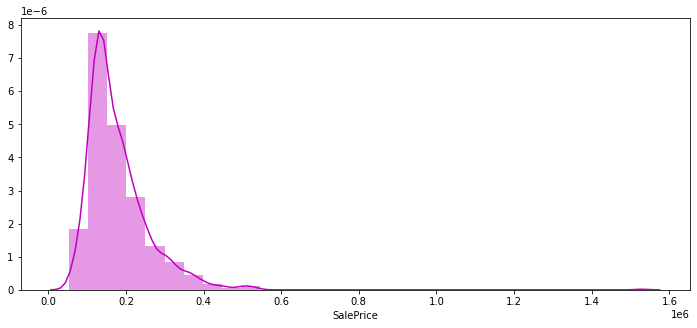

In [119]:
# plot results
plt.figure(figsize=(12,5))
sns.distplot(predictions["SalePrice"],bins=30, color='m')

In [120]:
predictions.to_csv("submit.csv", index=False)